In [3]:
import itertools
import tensorflow as tf
import pandas as pd
import numpy as np
import tqdm
import sys
# Local software setup
sys.path.append('..')

from tensorflow.keras.models import load_model
from scipy.spatial.distance import euclidean

from src.losses import custom_loss
from src.metrics import point_in_ellipse
from src.metrics import point_in_ellipse_numpy
from src.metrics import circle_area
from src.data_utils import sample_vertices
from src.data_utils import read_vertex_file

RANDOM_SEED = 13

In [234]:
path_to_model = "../data/models/tracknetv2_no_epoch100_eff9870_hits9967_loss2949_pie9863_area3.0235.h5"
custom_objects = {
    "_tracknet_loss": custom_loss,
    "point_in_ellipse": point_in_ellipse,
    "circle_area": circle_area}

model = load_model(path_to_model, custom_objects=custom_objects)

## Load data

#### Train

In [5]:
from src.data_utils import read_train_dataset

In [224]:
train_data = read_train_dataset(
    "../data/train/", 
    vertex_fname=None, 
    random_seed=RANDOM_SEED)

Processing `../data/train\CC4GeVmb_100_n50k.tsv` file...


100%|███████████████████████████████████████████████████████████████████████| 219334/219334 [00:04<00:00, 44579.91it/s]


Processing `../data/train\CC4GeVmb_101_n50k.tsv` file...


100%|███████████████████████████████████████████████████████████████████████| 220076/220076 [00:04<00:00, 48581.88it/s]


Processing `../data/train\CC4GeVmb_102_n50k.tsv` file...


100%|███████████████████████████████████████████████████████████████████████| 220422/220422 [00:04<00:00, 52369.32it/s]


Processing `../data/train\CC4GeVmb_103_n50k.tsv` file...


100%|███████████████████████████████████████████████████████████████████████| 219262/219262 [00:06<00:00, 34562.09it/s]


Processing `../data/train\CC4GeVmb_104_n50k.tsv` file...


100%|███████████████████████████████████████████████████████████████████████| 220049/220049 [00:06<00:00, 35606.64it/s]


Processing `../data/train\CC4GeVmb_105_n50k.tsv` file...


100%|███████████████████████████████████████████████████████████████████████| 219576/219576 [00:04<00:00, 44592.71it/s]


Processing `../data/train\CC4GeVmb_106_n50k.tsv` file...


100%|███████████████████████████████████████████████████████████████████████| 218909/218909 [00:05<00:00, 37860.35it/s]


Processing `../data/train\CC4GeVmb_107_n50k.tsv` file...


100%|███████████████████████████████████████████████████████████████████████| 219320/219320 [00:06<00:00, 33632.89it/s]


--[read_train_dataset] took 507.70 seconds to run.



In [225]:
test_data = read_train_dataset(
    "../data/test/", 
    vertex_fname=None, 
    random_seed=RANDOM_SEED)

Processing `../data/test\CC4GeVmb_108_n50k.tsv` file...


100%|███████████████████████████████████████████████████████████████████████| 219772/219772 [00:04<00:00, 44714.61it/s]


Processing `../data/test\CC4GeVmb_109_n50k.tsv` file...


100%|███████████████████████████████████████████████████████████████████████| 218951/218951 [00:05<00:00, 40145.11it/s]


Processing `../data/test\CC4GeVmb_110_n50k.tsv` file...


100%|███████████████████████████████████████████████████████████████████████| 219663/219663 [00:05<00:00, 43147.33it/s]


--[read_train_dataset] took 209.23 seconds to run.



### Get buckets with tracks of different length

In [230]:
def get_tracklens(data):
    # nonzero rows
    nonzero = np.count_nonzero(data, axis=-1)
    return np.sum(nonzero > 0, axis=1)

In [231]:
train_tracklens = get_tracklens(train_data)
test_tracklens = get_tracklens(test_data)

In [232]:
ulen = np.unique(test_tracklens)
buckets = {x: np.where(test_tracklens==x)[0] for x in ulen}

print('Buckets for testing')
for k in buckets.keys():
    print(k, ':', len(buckets[k]))

Buckets for testing
3 : 67625
4 : 44349
5 : 43225
6 : 503187


## Calculate hit accuracy and efficiency for tracks with different length

In [239]:
from src.metrics import calc_metrics
from src.data_utils import get_part

### Fixed vertex

In [117]:
accs, hit_accs = [], []

print('Test on buckets')
for k in buckets.keys():
    print('Tracklen: %d' % k)
    acc, hit_acc = calc_metrics(
        test_data[buckets[k]], 
        model, 
        tracklen=k)
    print('\tBucket size: %d' % len(buckets[k]))
    print('\tAccuracy: %.4f' % acc)
    print('\tHit accuracy: %.4f' % hit_acc)
    accs.append(acc)
    hit_accs.append(hit_acc)

Test on buckets
Tracklen: 4
	Bucket size: 67625
	Accuracy: 0.4160
	Hit accuracy: 0.2608
Tracklen: 5
	Bucket size: 44349
	Accuracy: 0.4911
	Hit accuracy: 0.4775
Tracklen: 6
	Bucket size: 43225
	Accuracy: 0.5673
	Hit accuracy: 0.6968
Tracklen: 7
	Bucket size: 503187
	Accuracy: 0.9594
	Hit accuracy: 0.9918


### No vertex

In [236]:
accs, hit_accs = [], []

print('Test on buckets')
for k in buckets.keys():
    print('Tracklen: %d' % k)
    acc, hit_acc = calc_metrics(
        test_data[buckets[k]], 
        model, 
        tracklen=k)
    print('\tBucket size: %d' % len(buckets[k]))
    print('\tAccuracy: %.4f' % acc)
    print('\tHit accuracy: %.4f' % hit_acc)
    accs.append(acc)
    hit_accs.append(hit_acc)

Test on buckets
Tracklen: 3
	Bucket size: 67625
	Accuracy: 0.9332
	Hit accuracy: 0.2333
Tracklen: 4
	Bucket size: 44349
	Accuracy: 0.7220
	Hit accuracy: 0.4285
Tracklen: 5
	Bucket size: 43225
	Accuracy: 0.7230
	Hit accuracy: 0.6757
Tracklen: 6
	Bucket size: 503187
	Accuracy: 0.9868
	Hit accuracy: 0.9967


## Plot results

In [215]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

### Fixed vertex

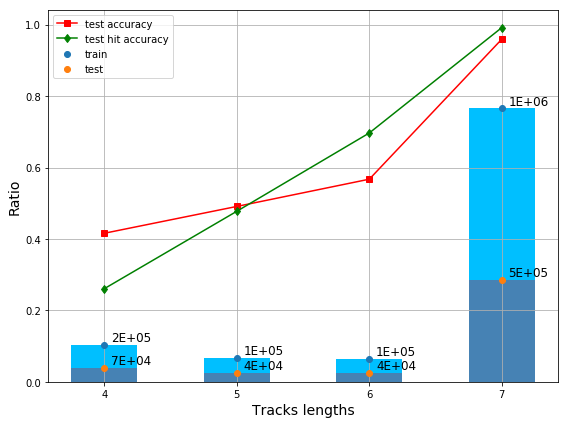

In [222]:
fig, ax = plt.subplots(figsize=(8, 6))

# tracks lengths
train_ulen, train_usize = np.unique(train_tracklens, return_counts=True)
test_ulen, test_usize = np.unique(test_tracklens, return_counts=True)

# normed sizes
normed_train_usize = train_usize / len(train_data)
normed_test_usize = test_usize / len(train_data)

# plot train
ax.bar(train_ulen, normed_train_usize, align='center', width=0.5, color='deepskyblue')
ax.scatter(train_ulen, normed_train_usize, zorder=10)
for x,y,s in zip(train_ulen, normed_train_usize, train_usize):
    ax.text(x+0.05, y+0.01, '%.E' % s, fontsize=12)
# plot test
ax.bar(test_ulen, normed_test_usize, align='center', width=0.5, color='steelblue')
ax.scatter(test_ulen, normed_test_usize, zorder=10)
for x,y,s in zip(test_ulen, normed_test_usize, test_usize):
    ax.text(x+0.05, y+0.01, '%.E' % s, fontsize=12)
# metrics
ax.plot(ulen, accs, marker='s', color='red')
ax.plot(ulen, hit_accs, marker='d', color='green')

# set up plot
ax.set_xticks(ulen)
plt.legend(['test accuracy', 'test hit accuracy', 'train', 'test'])
ax.set_xlabel('Tracks lengths', fontsize=14)
ax.set_ylabel('Ratio', fontsize=14)

plt.tight_layout()
plt.grid()

# save plot
plt.savefig('Metrics_fix_vertex.png', dpi=300)
plt.show()

### No vertex

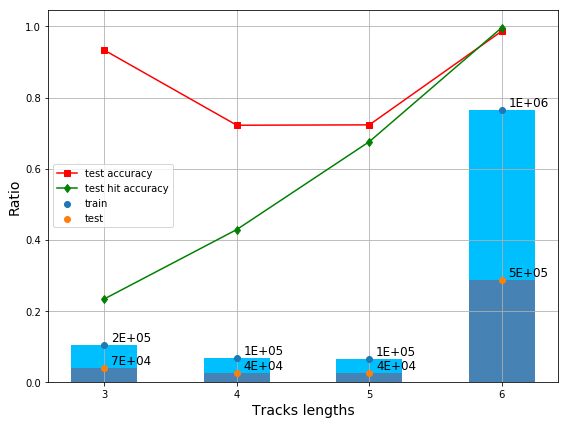

In [237]:
fig, ax = plt.subplots(figsize=(8, 6))

# tracks lengths
train_ulen, train_usize = np.unique(train_tracklens, return_counts=True)
test_ulen, test_usize = np.unique(test_tracklens, return_counts=True)

# normed sizes
normed_train_usize = train_usize / len(train_data)
normed_test_usize = test_usize / len(train_data)

# plot train
ax.bar(train_ulen, normed_train_usize, align='center', width=0.5, color='deepskyblue')
ax.scatter(train_ulen, normed_train_usize, zorder=10)
for x,y,s in zip(train_ulen, normed_train_usize, train_usize):
    ax.text(x+0.05, y+0.01, '%.E' % s, fontsize=12)
# plot test
ax.bar(test_ulen, normed_test_usize, align='center', width=0.5, color='steelblue')
ax.scatter(test_ulen, normed_test_usize, zorder=10)
for x,y,s in zip(test_ulen, normed_test_usize, test_usize):
    ax.text(x+0.05, y+0.01, '%.E' % s, fontsize=12)
# metrics
ax.plot(ulen, accs, marker='s', color='red')
ax.plot(ulen, hit_accs, marker='d', color='green')

# set up plot
ax.set_xticks(ulen)
plt.legend(['test accuracy', 'test hit accuracy', 'train', 'test'])
ax.set_xlabel('Tracks lengths', fontsize=14)
ax.set_ylabel('Ratio', fontsize=14)

plt.tight_layout()
plt.grid()

# save plot
plt.savefig('Metrics_no_vertex.png', dpi=300)
plt.show()